# Experiment Notebook for CV2

This notebook is a development workspace to add or subtract features during model development. Once a set of changes is ready to be experimented with, it should be cleaned, copied and saved to a new notebook that can be run end to end with no errors and committed in a separate git commit. For example, "fastai2_unet_trainer_cv2-1channel-baseline.ipynb" is an experiment that should not be changed in version control once committed but cells can be edited to inspect the results on your local machine.

In [56]:
bs_d ={512:4, 256:16, 224:16, 128:64, 64:256}

size=64
bs = bs_d[size]
n="all"
arch=34
epochs = 15
freeze = 3
negative_sample_count = 0
negative_sample_count_val = 0
area_thresh = 10

In [3]:
from ceruleanml import data
from ceruleanml import evaluation
from ceruleanml import preprocess
from fastai.data.block import DataBlock
from fastai.vision.data import ImageBlock, MaskBlock
from fastai.vision.augment import aug_transforms, Resize
from fastai.vision.learner import unet_learner
from fastai.data.transforms import IndexSplitter
from fastai.metrics import DiceMulti, Dice, accuracy_multi, PrecisionMulti, RecallMulti
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from torchvision.models import resnet18, resnet34, resnet50
from fastai.callback.fp16 import MixedPrecision
from fastai.callback.tensorboard import TensorBoardCallback
from fastai.vision.core import PILImageBW
from datetime import datetime
from pathlib import Path
import os, random
from icevision.visualize import show_data
import torch
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import skimage.io as skio
import numpy as np
from math import log


In [4]:

### Parsing COCO Dataset with Icevision

class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))
arch_d = {18: resnet18, 34: resnet34, 50: resnet50}


with_context=False
mount_path = "/root/"
train_set = "train-no-context-512"
tiled_images_folder_train = "tiled_images_no_context"
json_name_train = "instances_TiledCeruleanDatasetV2NoContextFiles.json"

coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
val_set = "val-no-context-512"
tiled_images_folder_val= "tiled_images_no_context"
json_name_val = "instances_TiledCeruleanDatasetV2NoContextFiles.json"
coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"

#with aux files
# with_context=True
# mount_path = "/root/"
# train_set = "train-with-context-512"
# tiled_images_folder_train = "tiled_images"
# json_name_train = "instances_TiledCeruleanDatasetV2.json"

# coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
# tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
# val_set = "val-with-context-512"
# tiled_images_folder_val= "tiled_images"
# json_name_val = "instances_TiledCeruleanDatasetV2.json"
# coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
# tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"


In [5]:

class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))

# f"{mount_path}/partitions/val/instances_tiled_cerulean_train_v2.json"

## looking at area distribution to find area threshold

# df = preprocess.get_area_df(coco_json_path_train, tiled_images_folder_train)
# df

record_collection_with_negative_small_filtered_train = preprocess.load_set_record_collection(
    coco_json_path_train, tiled_images_folder_train, area_thresh, negative_sample_count, preprocess=False
)
record_ids_train = record_collection_to_record_ids(record_collection_with_negative_small_filtered_train)

record_collection_with_negative_small_filtered_val = preprocess.load_set_record_collection(
    coco_json_path_val, tiled_images_folder_val, area_thresh, negative_sample_count_val, preprocess=False
)
record_ids_val = record_collection_to_record_ids(record_collection_with_negative_small_filtered_val)

assert len(set(record_ids_train)) + len(set(record_ids_val)) == len(record_ids_train) + len(record_ids_val)

train_val_record_ids = record_ids_train + record_ids_val
combined_record_collection = record_collection_with_negative_small_filtered_train + record_collection_with_negative_small_filtered_val

def get_val_indices(combined_ids, val_ids):
    return list(range(len(combined_ids)))[-len(val_ids):]

#show_data.show_records(random.choices(combined_train_records, k=9), ncols=3)

### Constructing a FastAI DataBlock that uses parsed COCO Dataset from icevision parser. aug_transforms can only be used with_context=True

val_indices = get_val_indices(train_val_record_ids, record_ids_val)

def get_image_by_record_id(record_id):
    return get_image_path(combined_record_collection, record_id)

def get_mask_by_record_id(record_id):
    return record_to_mask(combined_record_collection, record_id)

batch_transfms = [*aug_transforms(flip_vert=True, max_rotate=180, max_warp=0.1, size=size)]
coco_seg_dblock = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes=class_ints)), # ImageBlock is RGB by default, uses PIL
        get_x=get_image_by_record_id,
        splitter=IndexSplitter(val_indices),
        get_y=get_mask_by_record_id,
        batch_tfms=batch_transfms,
        item_tfms = Resize(size),
        n_inp=1
    )


dls = coco_seg_dblock.dataloaders(source=train_val_record_ids, batch_size=bs)

# dls.show_batch()

  0%|          | 0/3863 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


### Fastai2 Trainer

In [6]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
experiment_dir =  Path(f'{mount_path}/experiments/cv2/'+timestampStr+'_fastai_unet/')
experiment_dir.mkdir(exist_ok=True)
print(experiment_dir)

/root/experiments/cv2/17_Jun_2022_06_45_31_fastai_unet


In [7]:
b = dls.one_batch()

b[0].shape

torch.Size([256, 3, 64, 64])

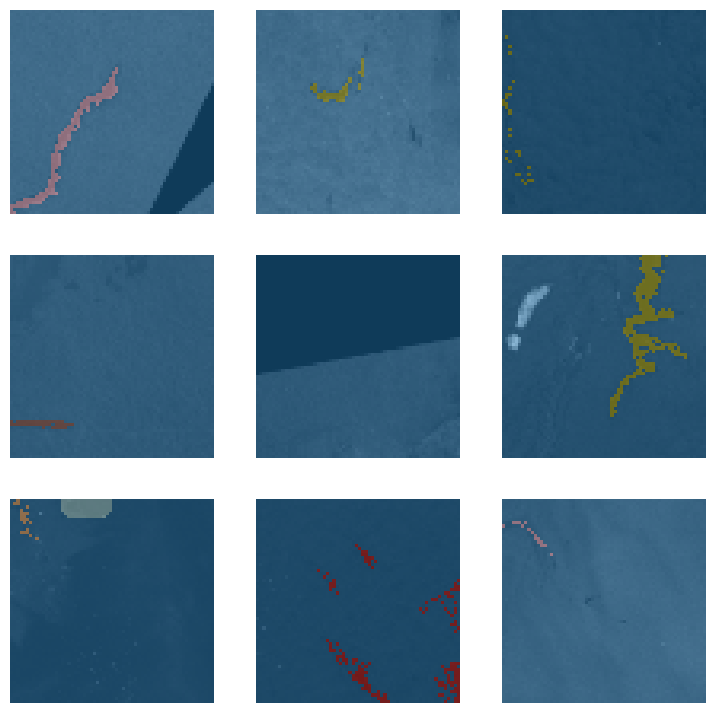

In [8]:
dls.show_batch()

In [35]:
cbs = [TensorBoardCallback(projector=False, trace_model=False), 
       SaveModelCallback(monitor="valid_loss", with_opt=True),
       # EarlyStoppingCallback(monitor='valid_loss', min_delta=0.005, patience=10) 
       ]

learner = unet_learner(dls, arch_d[arch], metrics=[DiceMulti, Dice],
                       model_dir=experiment_dir, n_out=7,
                       cbs=cbs) #cbs=cbs# SaveModelCallback saves model when there is improvement
# lr = learner.lr_find()

In [67]:
lr_d = {512:3e-4, 256:1e-3, 224:3e-3, 128:3e-3, 64:1e-2}
lr = lr_d[size]
# lr = learner.lr_find()
# lr

In [54]:
print("size", size)
print("batch size", bs)
print("arch", arch)
print("lr", lr)
print("n chips", n)
print("epochs", epochs)
print("freeze", freeze)

learner.fine_tune(epochs, lr, freeze_epochs=freeze) # cbs=cbs

size 64
batch size 256
arch 34
lr 0.01
n chips all
epochs 15
freeze 3


epoch,train_loss,valid_loss,dice_multi,dice,time
0,0.092435,0.069585,0.211570,1.149932,00:15
1,0.094240,0.066756,0.207976,1.309071,00:16
2,0.098931,0.139207,0.194899,1.496279,00:16


Better model found at epoch 0 with valid_loss value: 0.06958474218845367.
Better model found at epoch 1 with valid_loss value: 0.0667562261223793.


epoch,train_loss,valid_loss,dice_multi,dice,time
0,0.094354,0.065587,0.237714,1.247866,00:16
1,0.093057,0.066704,0.200611,0.767149,00:16
2,0.093659,0.068949,0.206073,1.221355,00:16
3,0.093829,0.083810,0.208176,1.226702,00:16
4,0.097730,0.073645,0.169149,0.656859,00:16
5,0.099214,0.071054,0.179993,0.818787,00:16
6,0.098930,0.079254,0.169715,0.738633,00:16
7,0.098121,0.068764,0.184982,1.094241,00:16
8,0.096125,0.065159,0.195115,0.962386,00:16
9,0.093952,0.063803,0.202771,1.055164,00:16


Better model found at epoch 0 with valid_loss value: 0.06558730453252792.
Better model found at epoch 8 with valid_loss value: 0.06515894830226898.
Better model found at epoch 9 with valid_loss value: 0.06380310654640198.
Better model found at epoch 10 with valid_loss value: 0.06297323852777481.
Better model found at epoch 12 with valid_loss value: 0.06160767003893852.


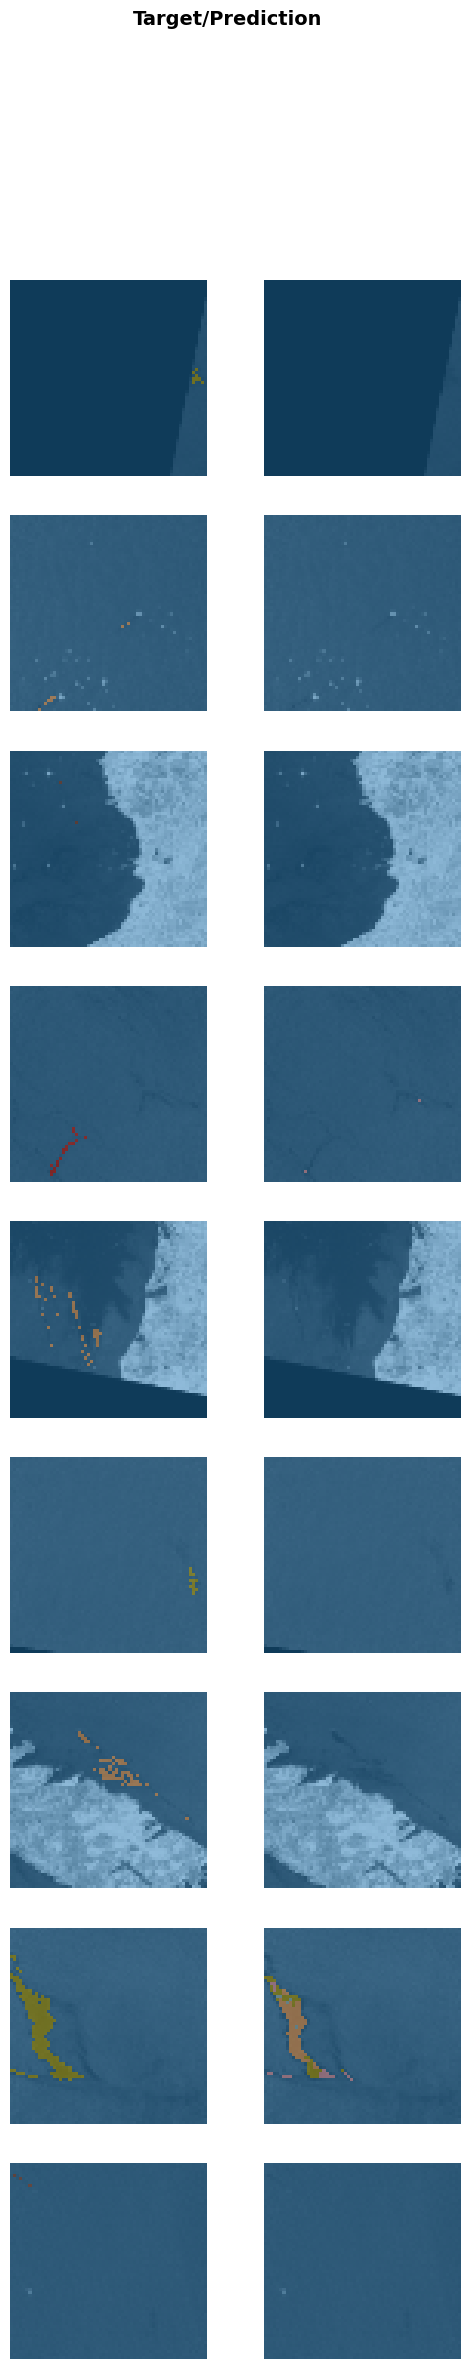

In [55]:
learner.show_results()

# Progressive Resizing

In [86]:
size= 128
bs = bs_d[size]
lr = lr_d[size]

batch_transfms = [*aug_transforms(flip_vert=True, max_rotate=180, max_warp=0.1, size=size)]
coco_seg_dblock = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes=class_ints)), # ImageBlock is RGB by default, uses PIL
        get_x=get_image_by_record_id,
        splitter=IndexSplitter(val_indices),
        get_y=get_mask_by_record_id,
        batch_tfms=batch_transfms,
        item_tfms = Resize(size),
        n_inp=1
    )
learner.dls = coco_seg_dblock.dataloaders(source=train_val_record_ids, batch_size=bs)

image size 512
batch size 4
arch 34
lr 0.0003
n chips all
epochs 15
freeze 3


epoch,train_loss,valid_loss,dice_multi,dice,time
0,0.106182,0.077542,0.190075,0.905368,10:39


Better model found at epoch 0 with valid_loss value: 0.07754248380661011.


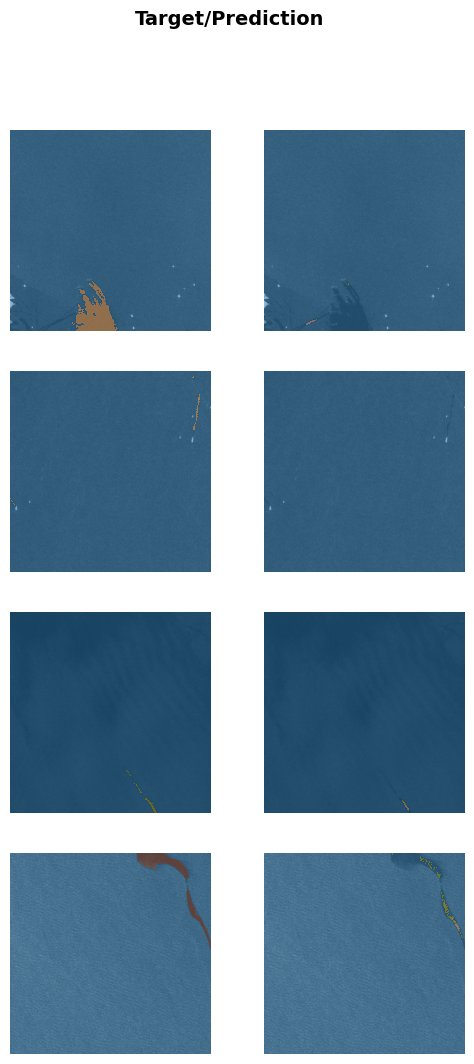

In [87]:
print("image size", size)
print("batch size", bs)
print("arch", arch)
print("lr", lr)
print("n chips", n)
print("epochs", epochs)
print("freeze", freeze)

learner.fine_tune(1, lr, freeze_epochs=0) # cbs=cbs
learner.show_results()

# Model Inference and Result Evaluation

In [ ]:
evaluation.get_cm_for_learner(dls, learner, mount_path)

In [ ]:
validation = learner.validate()

# We save the best model in a variety of formats for loading later. Eval on Torchscript model still being debugged

In [ ]:
save_template = f'test_{bs}_{arch}_{size}_{round(validation[1],3)}_{epochs}.pt'

In [ ]:
from ceruleanml.inference import save_fastai_model_state_dict_and_tracing, load_tracing_model, test_tracing_model_one_batch, logits_to_classes

state_dict_pth, tracing_model_gpu_pth, tracing_model_cpu_pth  = save_fastai_model_state_dict_and_tracing(learner, dls, save_template, experiment_dir)

In [ ]:
model = torch.load(tracing_model_cpu_pth)

In [ ]:
def get_cm_for_torchscript_model(dls, model, save_path):
"""
the torchscript model when it is loaded operates on batches, not individual images
this doesn't support eval on negative samples if they are in the dls, 
since val masks don't exist with neg samples. need to be constructed with np.zeros

returns cm and f1 score
"""
val_arrs = []
class_preds = []
for batch_tuple in dls.valid:
    semantic_masks_batch = batch_tuple[1].cpu().detach().numpy()
    class_pred_batch = model(batch_tuple[0].cpu())
    class_pred_batch = class_pred_batch.cpu().detach().numpy()
    val_arrs.extend(semantic_masks_batch)
    class_preds.append(class_pred_batch)
return evaluation.cm_f1(val_arrs, class_preds, 6, save_path) # todo add normalize false

In [ ]:
get_cm_for_torchscript_model(dls, model, mount_path)

In [ ]:
# this results in vm dying, not just kernel crash
# coco_seg_dblock = DataBlock(
#     blocks=(ImageBlock, MaskBlock(codes=class_ints)),
#     get_x=get_image_by_record_id,
#     get_y=get_mask_by_record_id,
#     n_inp=1,
# )

# dls = coco_seg_dblock.dataloaders(source=record_ids, batch_size=5)


In [ ]:
result = learner.get_preds(dl=dls[0])

In [ ]:
learner.get_preds??

In [ ]:
len(pred_arrs)

In [ ]:
target_label,prediction_arr, activations = pred_arrs[0]

In [ ]:
skio.imshow(target_label.cpu().detach().numpy())

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[0])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy())

In [ ]:
array([      60.73,       190.3,      4.3598]) # means
array([     16.099,      17.846,       9.603]) # stats